# Prediction of Country Based on The Percentage of Death Types

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
!pip install yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

## About Data
	Our dataset contains the causes of death and how the causes of death changed over time (1990-2019) between different countries and world regions.
	In this experiment, we tried to guess the country from number of deaths. To do this, firstly we find number of total deaths in this row and add it as last column of dataframe. Then, find percentage of death for all column which placed in that row. We do this to prevent overfitting of the data (For example, number of deaths are generally higher in high populated countries and lower in low populated countries. That means model may have a hard time using low values of low populated countries while training. So, we standardize data to make more precise predictions).


In [2]:
# Load the data into a Pandas DataFrame
df = pd.read_csv("annual_deaths_by_causes.csv")
raw_df = pd.read_csv("annual_deaths_by_causes.csv")

# Data Preprocessing

	We want to predict country from rate of mortality of diseases. So that, all diseases are important for us, and we didn’t drop any column from dataset to make better predictions. We only dropped ‘code’ column because it is identical with country column. Beside this, we make typical data preprocessing steps. Handling null values, dropping duplicates, converting categorical variables to the numerical variables by using label encoder on country column, standardizing data, and assigning mean to the null values in numerical variables.
	We didn’t handle outliers, because like we explained earlier, because of populations’ variance, deaths vary a lot too. In that case, A huge amount of data in dataset detected as outliers. So, dropping or assigning new values to the ‘outliers’ would be a huge deception and loss of data in the dataset.


In [3]:
# Create the LabelEncoder object
le = LabelEncoder()

# Fit the encoder to the "Category" column
le.fit(df["country"])

# Transform the values in the "Category" column
df["country"] = le.transform(df["country"])

df = df.rename(columns = {"alzheimer's_diesease" : "alzheimer's_disease"})
# We have changed column name, because there was a typographical error

In [4]:
#Dropped the unnecessary column
try:
    df = df.drop('code',axis=1)
except:
    pass
#Chose the first 20 features


#Check for null values
if df.isnull().any().any():
    #Replaced null values with mean
    for col in df[2:]:
        mean = df[col].mean()
        df[col] = df[col].fillna(mean)
        
# Check for and handle duplicate rows
df = df.drop_duplicates()


In [5]:
#Added a new column indicating total deaths by country
temp_df = df.drop(['year'],axis = 1)

df['total deaths'] = temp_df.sum(axis=1)

temp_df = df.drop(['country','year'],axis = 1)

df_divided = temp_df.div(df['total deaths'], axis=0)

df.loc[:,df.columns[2:]] = df_divided

df.head(3)


# Now,df data frame's death type columns are normalized according to total deaths 


,country,year,meningitis,alzheimer's_disease,parkinson's_disease,nutritional_deficiency,malaria,drowning,interpersonal_violence,maternal_disorders,...,poisonings,protein_energy_malnutrition,terrorism,road_injuries,chronic_respiratory_diseases,chronic_liver_diseases,digestive_diseases,fire_heat_hot_substance,acute_hepatitis,total deaths
0,0,2007,0.014322,0.006846,0.002197,0.012149,0.001919,0.010386,0.017857,0.024366,...,0.002500,0.011909,0.005855,0.036256,0.035264,0.016338,0.031534,0.002349,0.016783,1.0
1,0,2008,0.013641,0.007113,0.002273,0.011373,0.001274,0.009855,0.018905,0.025074,...,0.002472,0.011143,0.005454,0.036737,0.035678,0.016563,0.032007,0.002308,0.015009,1.0
2,0,2009,0.012556,0.007396,0.002348,0.010412,0.001220,0.009453,0.019773,0.025586,...,0.002465,0.010198,0.005436,0.037208,0.035957,0.016797,0.032451,0.002287,0.013592,1.0


# Data Exploration and Analysis

We analyze data with these steps: 

1-	Inspecting means and standard deviations of death types.

2-	Inspecting maximum and minimum death types and their numbers.

3-	Plotting the number of years for each country.

4-	Plotting a correlation heatmap for all columns and showing examples of it.


In [6]:
# Use Pandas functions to get a better understanding of the data
summary = raw_df.describe()
summary.head(3)


,year,meningitis,alzheimer's_diesease,parkinson's_disease,nutritional_deficiency,malaria,drowning,interpersonal_violence,maternal_disorders,hiv/aids,...,chronic_kidney_disease,poisonings,protein_energy_malnutrition,terrorism,road_injuries,chronic_respiratory_diseases,chronic_liver_diseases,digestive_diseases,fire_heat_hot_substance,acute_hepatitis
count,7273.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,...,6840.000000,6840.000000,6840.000000,2891.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000
mean,2004.425134,8213.149561,27363.188158,6493.627339,11006.353947,18903.160234,8619.055117,10636.648684,6131.066959,28141.249415,...,25068.928801,2145.455848,9531.528801,349.235905,30634.956140,91303.897661,31898.919006,56525.512135,3006.043275,3112.066520
std,8.623572,34982.933895,111314.606169,25767.447063,48289.687100,97346.780570,35879.406010,40888.793762,26355.210370,139197.345227,...,96008.391140,8433.507625,41689.675155,1917.143788,116699.865828,377201.308879,119438.677613,210988.351746,11211.885249,14440.219516


By inspecting this data frame, we can achieve number of that element, mean and standart deviation for that category.

In [7]:
types= summary.idxmax(axis=1).head(3).tolist()
numbers=summary.max(axis=1).head(3).tolist()
max_data = {'Types':types,'Numbers':numbers}
pd.DataFrame(max_data)

,Types,Numbers
0,year,7.273000e+03
1,cardiovascular_diseases,3.910080e+05
2,cardiovascular_diseases,1.508195e+06


By inspecting this data frame, we can conclude that, cardiovascular_diseases has largest standart deviation and mean. From this conclusion we can say, most of people die from cardiovascular_diseases and number of death in cardiovascular_diseases changes a lot among countries (because it has biggest std value).

In [8]:
types= summary.idxmin(axis=1).head(3).tolist()
numbers=summary.min(axis=1).head(3).tolist()
min_data = {'Types':types,'Numbers':numbers}
pd.DataFrame(min_data)

,Types,Numbers
0,terrorism,2891.000000
1,terrorism,349.235905
2,year,8.623572


By inspecting second data frame, we can say same things.Among every category, terrorism has small number of deaths and small deviation. It means among all countries, death from terrorism has closest values.


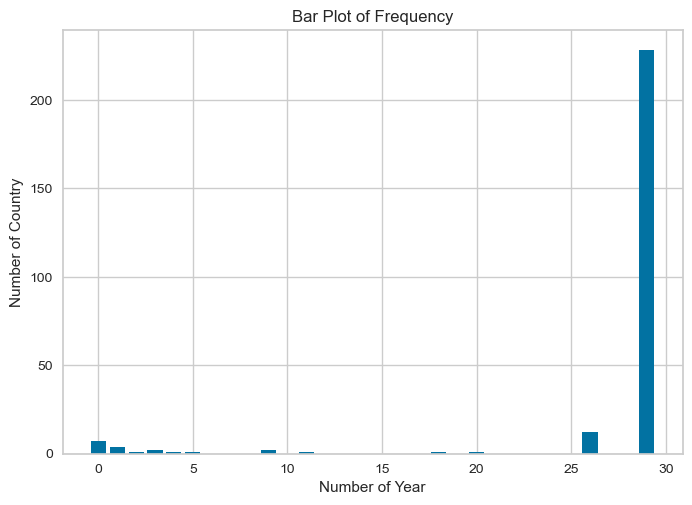

In [9]:
counter = []#It holds countries as df
for i in range(1,31):
    counter.append(raw_df["country"].value_counts().loc[(raw_df["country"].value_counts()==i).tolist()])
    
len_counter=[]# It holds number of countries and their lengths
for i in range(len(counter)):
    len_counter.append(len(counter[i]))
    
# Create the bar plot
plt.bar(range(len(len_counter)), len_counter)

# Add labels and show the plot
plt.xlabel("Number of Year")
plt.ylabel('Number of Country')
plt.title('Bar Plot of Frequency')
plt.show()

As we can see from the graph, a lot of countries have 30 rows (all years between 1990 and 2019) and some of countries doesn't have a value for some years.

<AxesSubplot:>

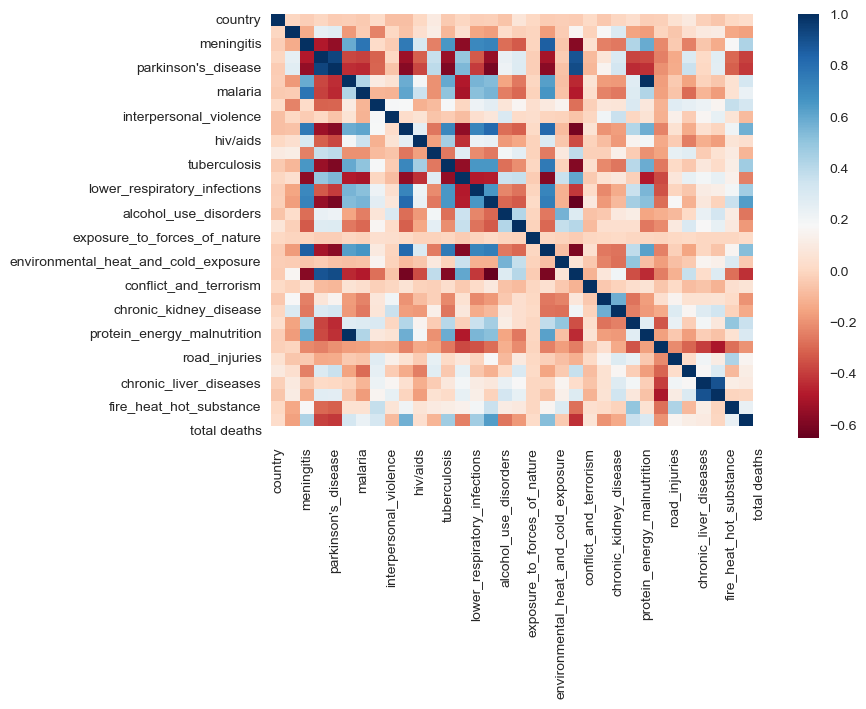

In [10]:
# Use visualization techniques to explore the data and identify trends or patterns
# Compute the pairwise correlations between columns
corr = df.corr()

# Generate a heatmap of the correlations
sns.heatmap(corr, cmap='RdBu', annot=False)

We can examine the correlation between data types by looking at the heat map

For example, there is obviously a positive correlation between parkinson and alzheimer and negative correlation between parkinson and meningitis.

Text(0.5, 1.0, 'Positive Correlation')

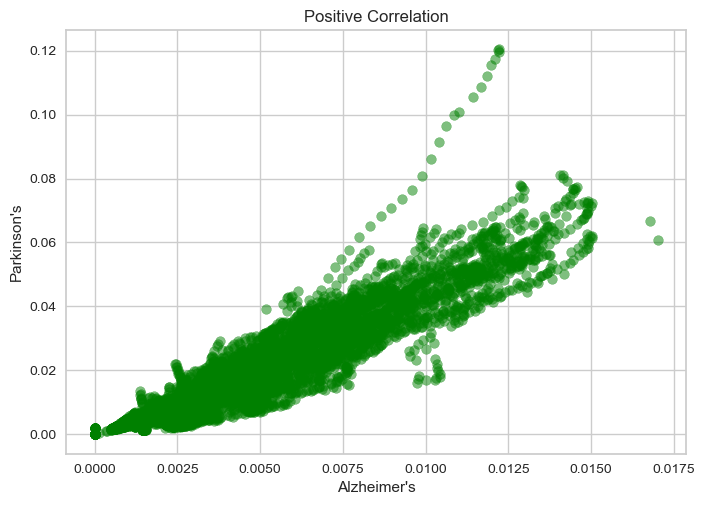

In [11]:
plt.scatter(df["parkinson's_disease"],df["alzheimer's_disease"],color = 'green',alpha = 0.5)
plt.xlabel("Alzheimer's")
plt.ylabel("Parkinson's")
plt.title("Positive Correlation")

Text(0.5, 1.0, 'Negative Correlation')

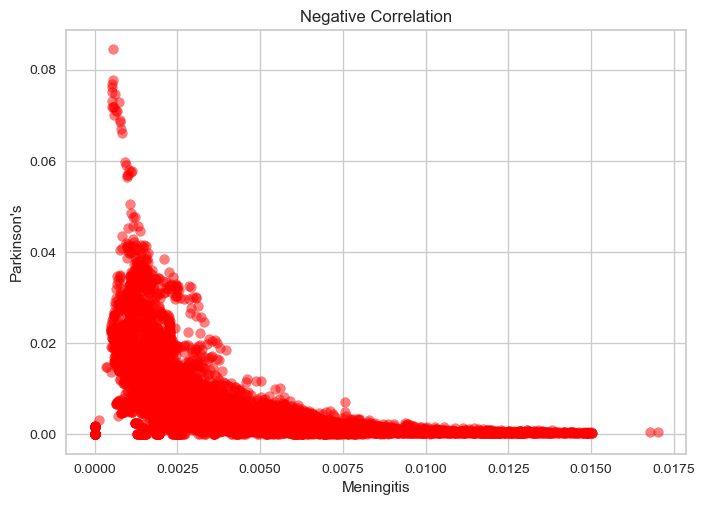

In [12]:
plt.scatter(df["parkinson's_disease"],df["meningitis"],color = 'red',alpha = 0.5)
plt.xlabel("Meningitis")
plt.ylabel("Parkinson's")
plt.title("Negative Correlation")

# Clustering 

	In clustering section, we used SelectKBest with k =2 to select a specified number of the best features from the dataset based on their statistical significance and then, used KMeans method to show clustering among them. Using Agglomerative Method wouldn’t be logical due to significance and instability of the dataset, we preferred to use KMeans for its simplicity, efficiency, scalability, and good cluster quality. We optimized KMeans parameters by using elbow function (to find the best k value), and used GridSearchCV to find optimal numbers for max_iter and n_init.
    
    After we plotted KMeans, we plotted Silhouette scores and found average as 0.59. A score of 0.59 indicates that the data points in a cluster are relatively well-separated from the points in other clusters.That proves that using KMeans as the method was the right choice for this dataset.


##### Dimension Reduction Using SelectKBest

In [13]:
# Extract useful features using SelectKBest
y = df['country'] 
# Y is the feature that we want to predict

X = df.drop('country', axis=1)
# X are the features that we will use to predict y

X_new = SelectKBest(score_func = chi2,k=2).fit_transform(X, y)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_new)

In [14]:
# This code part finds names of extracted two feature


find_names_of_features = SelectKBest(score_func = chi2,k=2).fit(X, y)
mask = find_names_of_features.get_support()#This contains names

# Create a list of the original feature names
feature_names = X.columns

# Use the mask to filter out the non-selected features
selected_features = [feature_names[i] for i in range(len(mask)) if mask[i]]

print("Number of Selected Features : ",len(X_new[0]))
# Print the selected features
for i in range(len(selected_features)):
    print(i+1,end="")
    print(". Selected Feature's Name : ",selected_features[i])



Number of Selected Features :  2
1. Selected Feature's Name :  hiv/aids
2. Selected Feature's Name :  terrorism


Note: SelectKBest function selects most relevant features from a larger set of features by using statistical tests (we use chi2), and k indicates how many variable will return from this function. As we can see from output, SelectKBest return 2 most relevant feature. Those are hiv/aids and terrorism.

<Figure size 800x550 with 0 Axes>

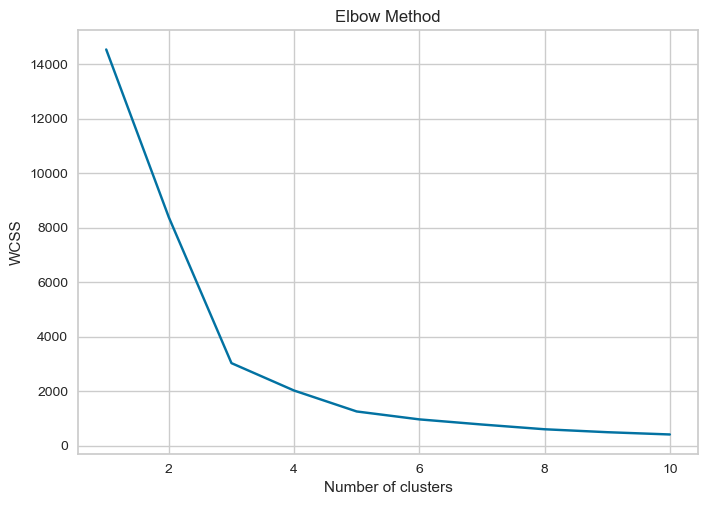

<Figure size 800x550 with 0 Axes>

In [15]:
# Apply the elbow method to determine the optimal number of clusters for K-Means
wcss = []
for i in [1,2,3,4,5,6,7,8,9,10]:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot([1,2,3,4,5,6,7,8,9,10], wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.figure()

Optimal number for cluster is 3. Because of the difference of derivation in lines, between points 2-3 and 3-4 is biggest compared to other paired lines.


In [16]:
# Define the range of values for max_iter
param_grid = {'max_iter': [10, 50, 100, 500, 1000]}

# Create the KMeans model
kmeans = KMeans()

# Create the grid search object
grid_search = GridSearchCV(kmeans, param_grid, cv=5)

# Fit the grid search object to the data
grid_search.fit(X)

# Print the best value for max_iter
print(grid_search.best_params_)

best_iter =grid_search.best_params_

{'max_iter': 500}


##### Warning : This section takes few seconds for calculation, you may don't want to run this line
##### Note : Best value is 100

In [17]:
# Define the range of values for n_init
param_grid = {'n_init': [10, 50, 100, 500, 1000]}

# Create the KMeans model
kmeans = KMeans()

# Create the grid search object
grid_search = GridSearchCV(kmeans, param_grid, cv=5)

# Fit the grid search object to the data
grid_search.fit(X)

# Print the best value for n_init
print(grid_search.best_params_)
best_init = grid_search.best_params_

{'n_init': 10}


<Figure size 800x550 with 0 Axes>

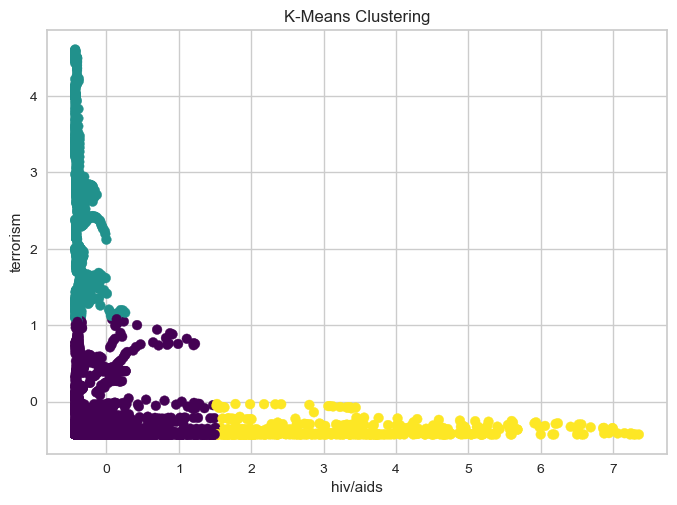

<Figure size 800x550 with 0 Axes>

In [18]:
# Build the K-Means model with the optimal number of clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=best_iter["max_iter"] , n_init=best_init["n_init"], random_state=0)
pred_kmeans = kmeans.fit_predict(X_scaled)



# Plot the clusters formed by the K-Means model
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=pred_kmeans, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.figure()

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=100, n_clusters=3,
                                      random_state=42))

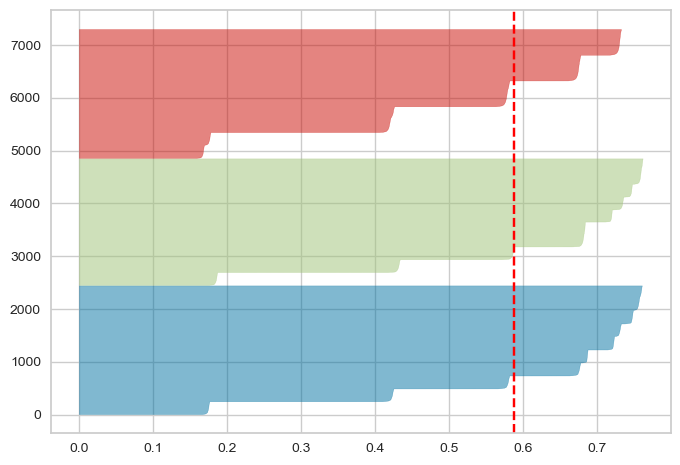

In [19]:
#Create KMeans instance for different number of clusters

km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=42)


#Create SilhouetteVisualizer instance with KMeans instance
#Fit the visualizer
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(X) 

By looking the Silhouette Score, 0.59 can be considered as a good score. A score of 0.59 indicates that the data points in a cluster are relatively well-separated from the points in other clusters.

# Model Prediction


	We chose decision tree for the first classification algorithm. Because decision trees can handle a wide range of data types and can work with both numerical and categorical features and decision trees are able to handle complex relationships between features and the target variable, making them suitable for tasks with non-linear relationships.It also works well under imbalanced data such as our dataset because we didn’t drop outliers.
	We wanted to choose kNN for second classification algorithm but the  best k value was 1 and even though it has overfitted, it’s accuracy was 0. So we chose random forest for second classification algorithm. Because Random forests tend to be highly accurate, as they can handle complex relationships in the data and reduce the risk of overfitting. While individual decision trees can be difficult to interpret, the overall prediction of the random forest can still be understood by examining the relative importance of the features and the decisions made by the individual trees. 


In [20]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [21]:
# Choose two classification algorithms to compare,decision tree and random forest

decision_tree = DecisionTreeClassifier(random_state = 0)
# Train the classifier on the training data

decision_tree.fit(X_train,y_train)
# Make predictions on the test data
y_pred_dt = decision_tree.predict(X_test)

# Evaluate the performance of the classifier
accuracy_dt = decision_tree.score(X_test, y_test)

## Find Optimum Value For param_grid
##### Warning : This section takes few minutes for calculation, you may don't want to run this line
##### Note : Best value is 500

In [22]:
#We should choose the optimal value of n_estimator
# Define the hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300, 400, 500]}

# Create a Random Forest classifier
random_forest = RandomForestClassifier(random_state=0)

# Create the grid search object
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X, y)

# Print the optimal value for n_estimators
print('Optimal value for n_estimators:', grid_search.best_params_['n_estimators'])

Optimal value for n_estimators: 500


##### Warning : This section takes few seconds for calculation, you may don't want to run this line

In [23]:
#Training Random Forest
random_forest = RandomForestClassifier(random_state=0,n_estimators =500)
random_forest.fit(X_train,y_train)
y_pred_rf = random_forest.predict(X_test)
accuracy_rf = random_forest.score(X_test,y_test)

# Model Evaluation and Visualizations

In [24]:
print('Accuracy of Decision Tree:', accuracy_dt)
print('Accuracy of Random Forest:', accuracy_rf)

Accuracy of Decision Tree: 0.9087992667277727
Accuracy of Random Forest: 0.9670027497708524


In [25]:
# Calculate the F1 score using the micro average
f1 = f1_score(y_test, y_pred_dt, average='micro')
print('F1 score for Decision Tree:', f1)
f1_ = f1_score(y_test, y_pred_rf, average='micro')
print('F1 score for Random Forest:', f1_)

F1 score for Decision Tree: 0.9087992667277727
F1 score for Random Forest: 0.9670027497708524


In [26]:
# Calculate precision
precision_dt = precision_score(y_test, y_pred_dt,average = 'micro')
precision_rf = precision_score(y_test, y_pred_rf,average = 'micro')
print('Precision for Decision Tree:', precision_dt)
print('Precision for Random Forest:', precision_rf)

Precision for Decision Tree: 0.9087992667277727
Precision for Random Forest: 0.9670027497708524


In [27]:
#Calculate recall
recall_dt = recall_score(y_test, y_pred_dt,average = 'micro')
recall_rf = recall_score(y_test, y_pred_rf,average = 'micro')
print('Recall for Decision Tree:', recall_dt)
print('Recall for Random Forest:', recall_rf)

Recall for Decision Tree: 0.9087992667277727
Recall for Random Forest: 0.9670027497708524


### We found f1 score, accuracy, precision and recall the has high score and they all same. It shows that our models overfitting while training

Text(72.72222222222221, 0.5, 'Actual Class')

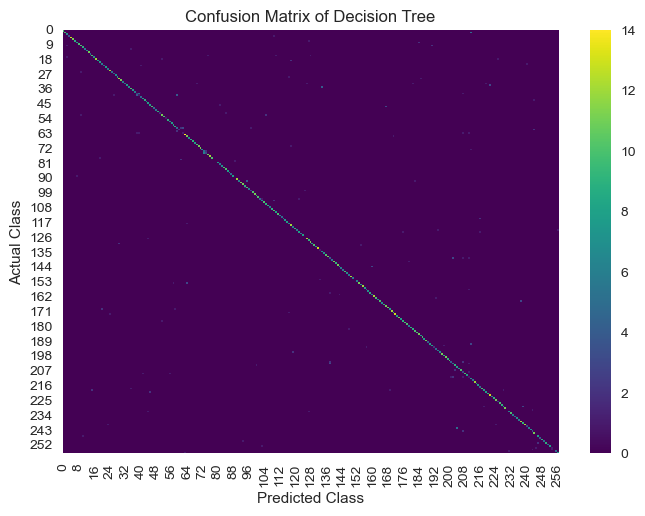

In [28]:
# Calculate the confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
# Create a heatmap using seaborn
sns.heatmap(cm_dt,fmt='d',cmap = 'viridis')

# Add a title and axis labels
plt.title('Confusion Matrix of Decision Tree')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

Text(72.72222222222221, 0.5, 'Actual Class')

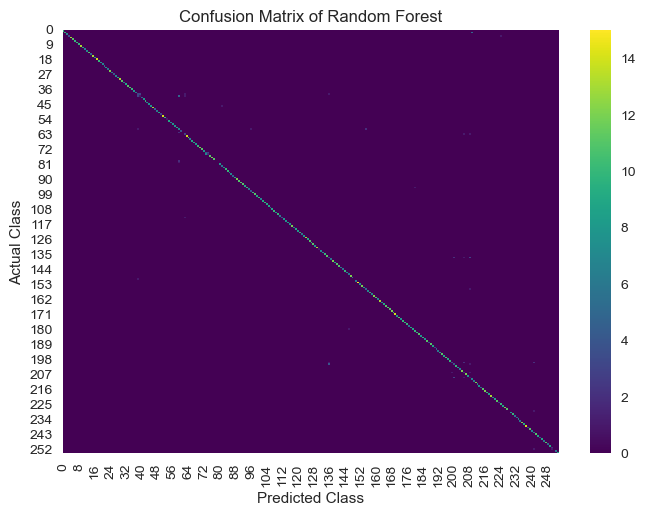

In [29]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Create a heatmap using seaborn
sns.heatmap(cm_rf,fmt='d',cmap = 'viridis')

# Add a title and axis labels
plt.title('Confusion Matrix of Random Forest')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

By looking at confusion matrixes we can say, our models not good as much accuracy says.

Text(0, 0.5, 'True Positive Rate')

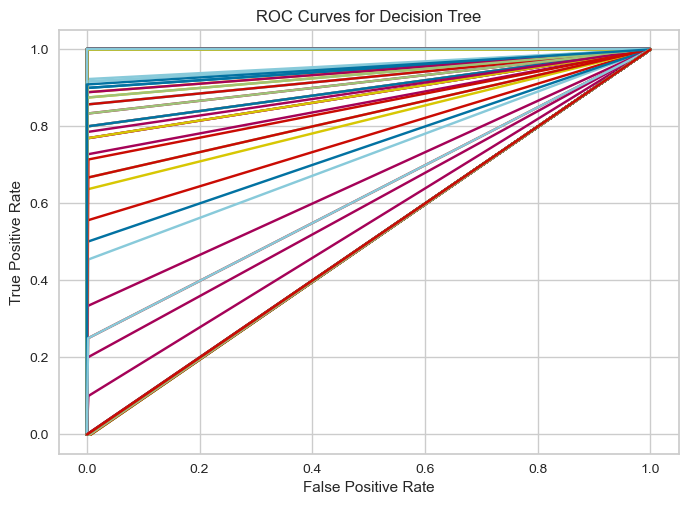

In [30]:
# Loop through each class and plot the ROC curve
y_score_dt = decision_tree.predict_proba(X_test)
for i in range(255):
    # Get the class indices for y_test and y_score
    class_test = y_test == i
    class_score = y_score_dt[:, i]

    # Compute the ROC curve for this class
    fpr, tpr, thresholds = roc_curve(class_test, class_score)

    # Plot the ROC curve
    plt.plot(fpr, tpr)
# Add a title and axis labels
plt.title('ROC Curves for Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


Text(0, 0.5, 'True Positive Rate')

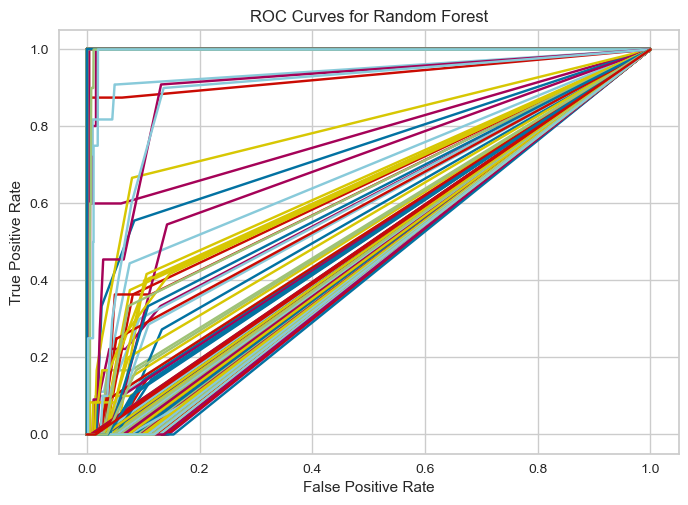

In [31]:
# Loop through each class and plot the ROC curve
y_score_rf = random_forest.predict_proba(X_test)
for i in range(255):
    # Get the class indices for y_test and y_score
    class_test = y_test == i
    class_score = y_score_rf[:, i]

    # Compute the ROC curve for this class
    fpr, tpr, thresholds = roc_curve(class_test, class_score)

    # Plot the ROC curve
    plt.plot(fpr, tpr)
# Add a title and axis labels
plt.title('ROC Curves for Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


By looking ROC curves we can claim that, Desicion Tree is much better thant Random Forest

Text(0, 0.5, 'Precision')

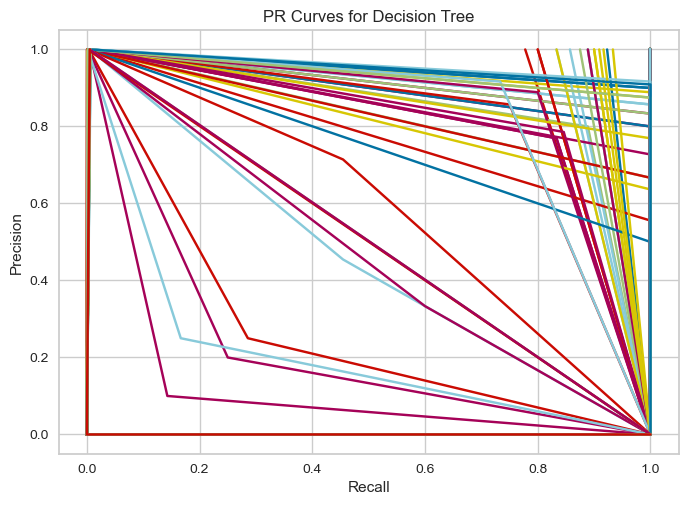

In [32]:
# Loop through each class and plot the PR curve
for i in range(255):
    # Get the class indices for y_test and y_score
    class_test = y_test == i
    class_score = y_score_dt[:, i]

    # Compute the PR curve for this class
    precision, recall, thresholds = precision_recall_curve(class_test, class_score)

    # Plot the PR curve
    plt.plot(precision, recall)
# Add a title and axis labels
plt.title('PR Curves for Decision Tree')
plt.xlabel('Recall')
plt.ylabel('Precision')

Text(0, 0.5, 'Precision')

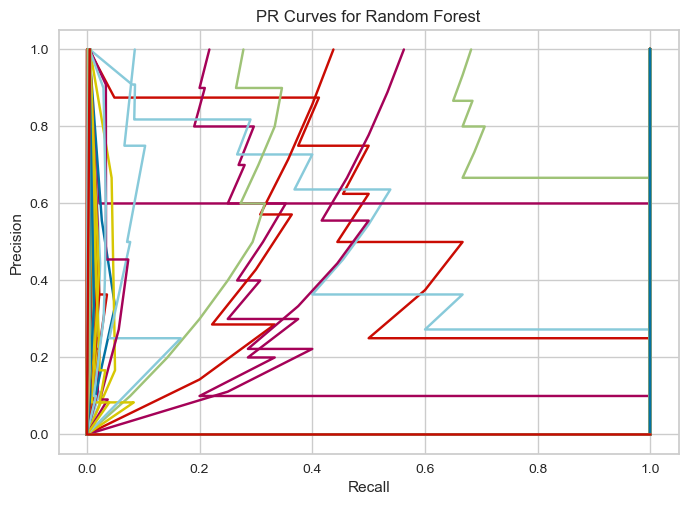

In [33]:
# Loop through each class and plot the PR curve
for i in range(255):
    # Get the class indices for y_test and y_score
    class_test = y_test == i
    class_score = y_score_rf[:, i]

    # Compute the PR curve for this class
    precision, recall, thresholds = precision_recall_curve(class_test, class_score)

    # Plot the PR curve
    plt.plot(precision, recall)
# Add a title and axis labels
plt.title('PR Curves for Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')

By looking PR curves,again we can claim that Decision Tree is better than Random Forest for this data. By looking PR Curves for Random Forest and accuracy of it, we can claim, Random Forest has overfitted. So if we want a model to predict country, we may want to choose Desicion Tree rather than the Random Forest

# Model Comparison and Result

    We found f1 score, accuracy, precision and recall and they had high score and were all same. It indicates that our models are overfitting while training.  To prevent the overfitting, we need larger training set (It trains countries with at most 30 different variables. It is smaller for some countries). We also may choose different models, but we think decision tree and random forest are the best among others under this conditions. (We have large data and small training set for each country and out data is so various)
    By looking confusion matrixes, PR Curves and ROC Curves for both models we can claim that our models not good as much accuracy says because they had overfitted. Although the precision of Decision Tree is lower than Random Forest, we may want to pick Decision Tree instead Random Forest because it has better result for PR Curve and ROC Curve.
	Summary, we can say that both models are far from being valid models for the dataset. Because dataset is massive and In order to predict the correct values, it should be carefully divided by the countries’ populations and trained for each dataset, so we can have a slightly better data. But best of the worse, Decision Tree model is the model we will pick in this case. 
